In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

# Raw data

In [2]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0
C11_11,11_11,D_11,11,C,29.0,T11,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


In [3]:
data = pd.read_csv('../Data/16S/picrust2_out_pipeline/pathways_out/path_abun_unstrat.tsv', sep='\t', index_col=0)
data.columns = ['C11_10' if i=='11_10' else i for i in data.columns]
data.shape
data.head(2)

(412, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
pathway,,,,,,,,,,,,,,,,,,,,,
1CMET2-PWY,10060.919209,6611.960926,12429.300543,11143.305746,21296.739095,16342.105287,15632.713319,6301.17746,11131.373797,22650.873480,...,9710.866291,10077.298691,9355.237385,7216.053727,5728.952011,23369.157159,6161.975489,5675.748014,12025.493906,10646.625483
3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,7952.820740,65.199695,57.754489,362.935135,49.717529,0.000000,209.220207,0.00000,21.633023,15.620458,...,0.000000,0.000000,0.000000,0.000000,0.000000,183.049957,1168.350596,0.000000,0.000000,13.650455


In [4]:
anno = pd.read_csv('../Data/16S/picrust2_out_pipeline/pathways_out/MetaCYC_annotation.tsv', sep='\t', index_col=0)
anno = anno.loc[data.index, :]
anno = anno.drop_duplicates()
anno.shape

level2pathway = {}
for i in set(data.index):
    if type(anno.loc[i, 'Annotation'])!=str:
        levels = []
        for j in anno.loc[i, 'Annotation']:
            levels.append(j.split(';'))
    else:
        levels = [anno.loc[i, 'Annotation'].split(';')]
    for j in levels:
        if j[1].strip()=='L_2__Superpathways':
            continue
        level2pathway[j[2]] = level2pathway.get(j[2], set())
        level2pathway[j[2]].add(i)
len(level2pathway)

(676, 2)

58

# 1. the abundance of functions

In [5]:
data_level = pd.DataFrame(columns=data.columns)
for level, paths in level2pathway.items():
    data_level.loc[level, :] = data.loc[paths, :].sum().values
data_level_rel = data_level/data_level.sum()*100
path_order = data_level_rel.mean(1).sort_values(ascending=False).index

In [6]:
sample_order = []
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
for t in Times:
    samples = meta.loc[meta['Time']==t, :].index
    temp = data_level_rel.loc[path_order[:3], samples].T
    samples = temp.sort_values([path_order[0], path_order[1], path_order[2]], ascending=False).index
    sample_order.extend(samples)

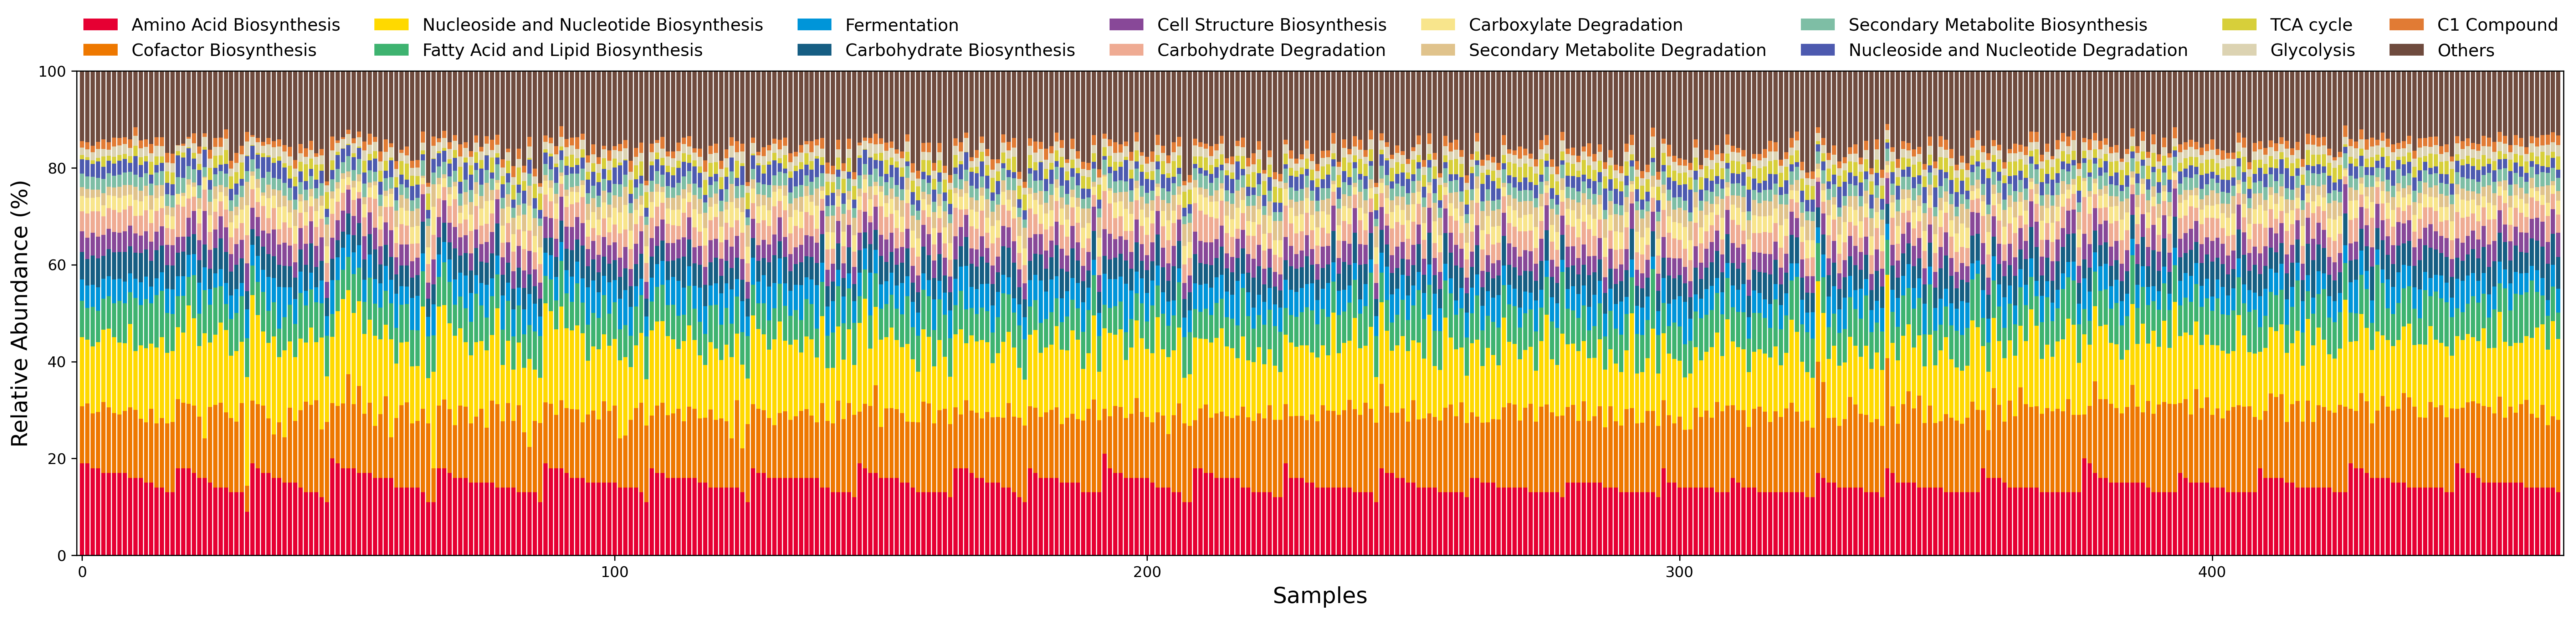

In [69]:
fig = plt.figure(figsize=(30, 6), dpi=300)
top = 15
colors = ['#e60033', '#ee7800', '#ffd900', '#3eb370', '#0095d9', '#165e83', '#884898', 
          '#efab93', '#f8e58c', '#e0c38c', '#7ebea5', '#4d5aaf', '#d7cf3a', '#dcd3b2',
          '#e17b34', '#6f4b3e']
path_name = {'Cofactor, Prosthetic Group, Electron Carrier, and Vitamin Biosynthesis':'Cofactor Biosynthesis', 
             'C1 Compound Utilization and Assimilation':'C1 Compound'}
bottom = np.array([0 for i in range(data_level_rel.shape[1])])
for i in range(top):
    values = data_level_rel.loc[path_order[i], sample_order]
    _ = plt.bar(x=range(len(sample_order)), height=values, width=0.8, bottom=bottom, 
                color=colors[i], label=path_name.get(path_order[i].split('_')[-1].strip(), 
                                                     path_order[i].split('_')[-1].strip()))
    bottom += values
_ = plt.bar(x=range(len(sample_order)), height=100-bottom, width=0.8, bottom=bottom, 
            color=colors[top], label='Others')
_ = plt.xlim([-1, len(sample_order)+0])
_ = plt.ylim([0, 100])
_ = plt.legend(loc=(0.00, 1.01), frameon=False, ncol=8, fontsize=11.5)
_ = plt.ylabel('Relative Abundance (%)', fontsize=15)
_ = plt.xlabel('Samples', fontsize=15)
fig.savefig('../Results_0609/4.1. pathway占比_门水平.pdf', dpi=300)

# 2. Correlation between clinical factors and functions

## 2.1 Differential functions between mothers and infants

In [8]:
def diff_analysis(data, control_samples, disease_samples):
    '''
    # data : data set with sample in index and item in columns
    # control_samples : control samples row index
    # disease_samples : disease samples row index
    # return : statistic table
    '''
    from scipy.stats import fisher_exact, ranksums, wilcoxon
    import statsmodels.stats.multitest as multi
    statistics = []
    for item in data.columns:
        control_exp = data.loc[control_samples, item]
        disease_exp = data.loc[disease_samples, item]
        try:
            f, p_value = ranksums(disease_exp, control_exp) # wilcoxon 成组非参检验 / ranksums 秩和检验
        except:
            f, p_value = 0, 1.0
        FC = disease_exp.mean()/control_exp.mean() if control_exp.mean()!=0 else np.inf
        statistics.append([item, len(control_samples), len(disease_samples), control_exp.mean(), disease_exp.mean(), FC, p_value])
    statistics = pd.DataFrame(statistics, index = data.columns, columns = ['ID', 'N_control', 'N_disease', 'AveExpr_control', 'AveExpr_disease', 'FC','P.Value'])
    statistics['adj.P.Val'] = multi.multipletests(statistics['P.Value'], method = 'fdr_bh')[1]
    statistics['logFC'] = np.log2(statistics['FC'])
    statistics = statistics.sort_values('P.Value')
    return statistics

In [70]:
pathways = pd.read_csv('../Data/16S/picrust2_out_pipeline/pathways_out/metacyc_pathways_info.txt', sep='\t', index_col=0, header=None)

In [71]:
control_samples = meta.loc[meta['Time']=='M', :].index
disease_samples = meta.loc[meta['Time']!='M', :].index
stats_res = diff_analysis(data.T, control_samples, disease_samples)
stats_res.columns = ['ID', 'N_Mother', 'N_Child', 'AveExpr_Mother', 'AveExpr_Child', 'FC','P.Value', 'adj.P.Val', 'logFC']
stats_res['Name'] = pathways.loc[stats_res.index, 1]
level = []
for i in stats_res.index:
    l = anno.loc[i, 'Annotation']
    if type(l) == str:
        level.append(l)
    else:
        level.append('|'.join(l.values))
stats_res['Level'] = level

In [73]:
classmap = {'polymyxin resistance':'L_3__Cell Structure Biosynthesis', 
            'superpathway of (Kdo)2-lipid A biosynthesis':'L_3__Fatty Acid and Lipid Biosynthesis', 
            'hexitol fermentation to lactate, formate, ethanol and acetate':'L_3__Fermentation', 
            'D-glucarate degradation I':'L_3__Carboxylate Degradation', 
            'pyrimidine deoxyribonucleotides de novo biosynthesis I':'L_3__Nucleoside and Nucleotide Biosynthesis', 
            'superpathway of phenylethylamine degradation':'L_3__Aromatic Compound Degradation', 
            '4-aminobutanoate degradation V':'L_3__Fermentation', 
            'pyrimidine deoxyribonucleotide phosphorylation':'L_3__Nucleoside and Nucleotide Biosynthesis', 
            'L-1,2-propanediol degradation':'L_3__Fermentation', 
            'peptidoglycan biosynthesis V (&beta;-lactam resistance)':'L_3__Cell Structure Biosynthesis', 
            'D-galactarate degradation I':'L_3__Carboxylate Degradation', 
            'acetylene degradation':'L_3__Fermentation', 
            'superpathway of geranylgeranyldiphosphate biosynthesis I (via mevalonate)':'L_3__Cofactor, Prosthetic Group, Electron Carrier, and Vitamin Biosynthesis',
            
            'aspartate superpathway':'L_3__Amino Acid Biosynthesis', 
            'superpathway of histidine, purine, and pyrimidine biosynthesis':'L_3__Amino Acid Biosynthesis', 
            'superpathway of D-glucarate and D-galactarate degradation':'L_3__Carbohydrate Degradation', 
            'superpathway of chorismate metabolism':'Unassigned', 
            'superpathway of S-adenosyl-L-methionine biosynthesis':'Unassigned'}

path2class = {}
for i in stats_res.index:
    if stats_res.loc[i, 'adj.P.Val']<=0.05 and stats_res.loc[i, 'logFC']>np.log2(1.5):
        l = stats_res.loc[i, 'Level'].split('|')
        level_class = set()
        for j in l:
            if j.split(';')[1].strip()!='L_2__Superpathways':
                level_class.add(j.split(';')[2])
        if stats_res.loc[i, 'Name'] in classmap.keys():
            level_class = [classmap[stats_res.loc[i, 'Name']]]
        if len(level_class)==0:
            '###', stats_res.loc[i, 'Name']
            l
        elif len(level_class)>1:
            '$$$', stats_res.loc[i, 'Name']
            level_class
        else:
            path2class[i] = list(level_class)[0]

In [100]:
stats_res['Class'] = [path2class.get(i, 'Unassigned') for i in stats_res.index]
stats_res['Ccolor_orderolor'] = [colors[list(path_order).index(i)] if i in path_order[:15] else '#dcdddd' for i in stats_res['Class']]
stats_res['Colors_legend'] = [path_name.get(i.split('_')[-1].strip(), i.split('_')[-1].strip()) if i in path_order[:15] else 'Others' for i in stats_res['Class']]
color_order = [path_name.get(i.split('_')[-1].strip(), i.split('_')[-1].strip()) for i in path_order[:15]] + ['Others']

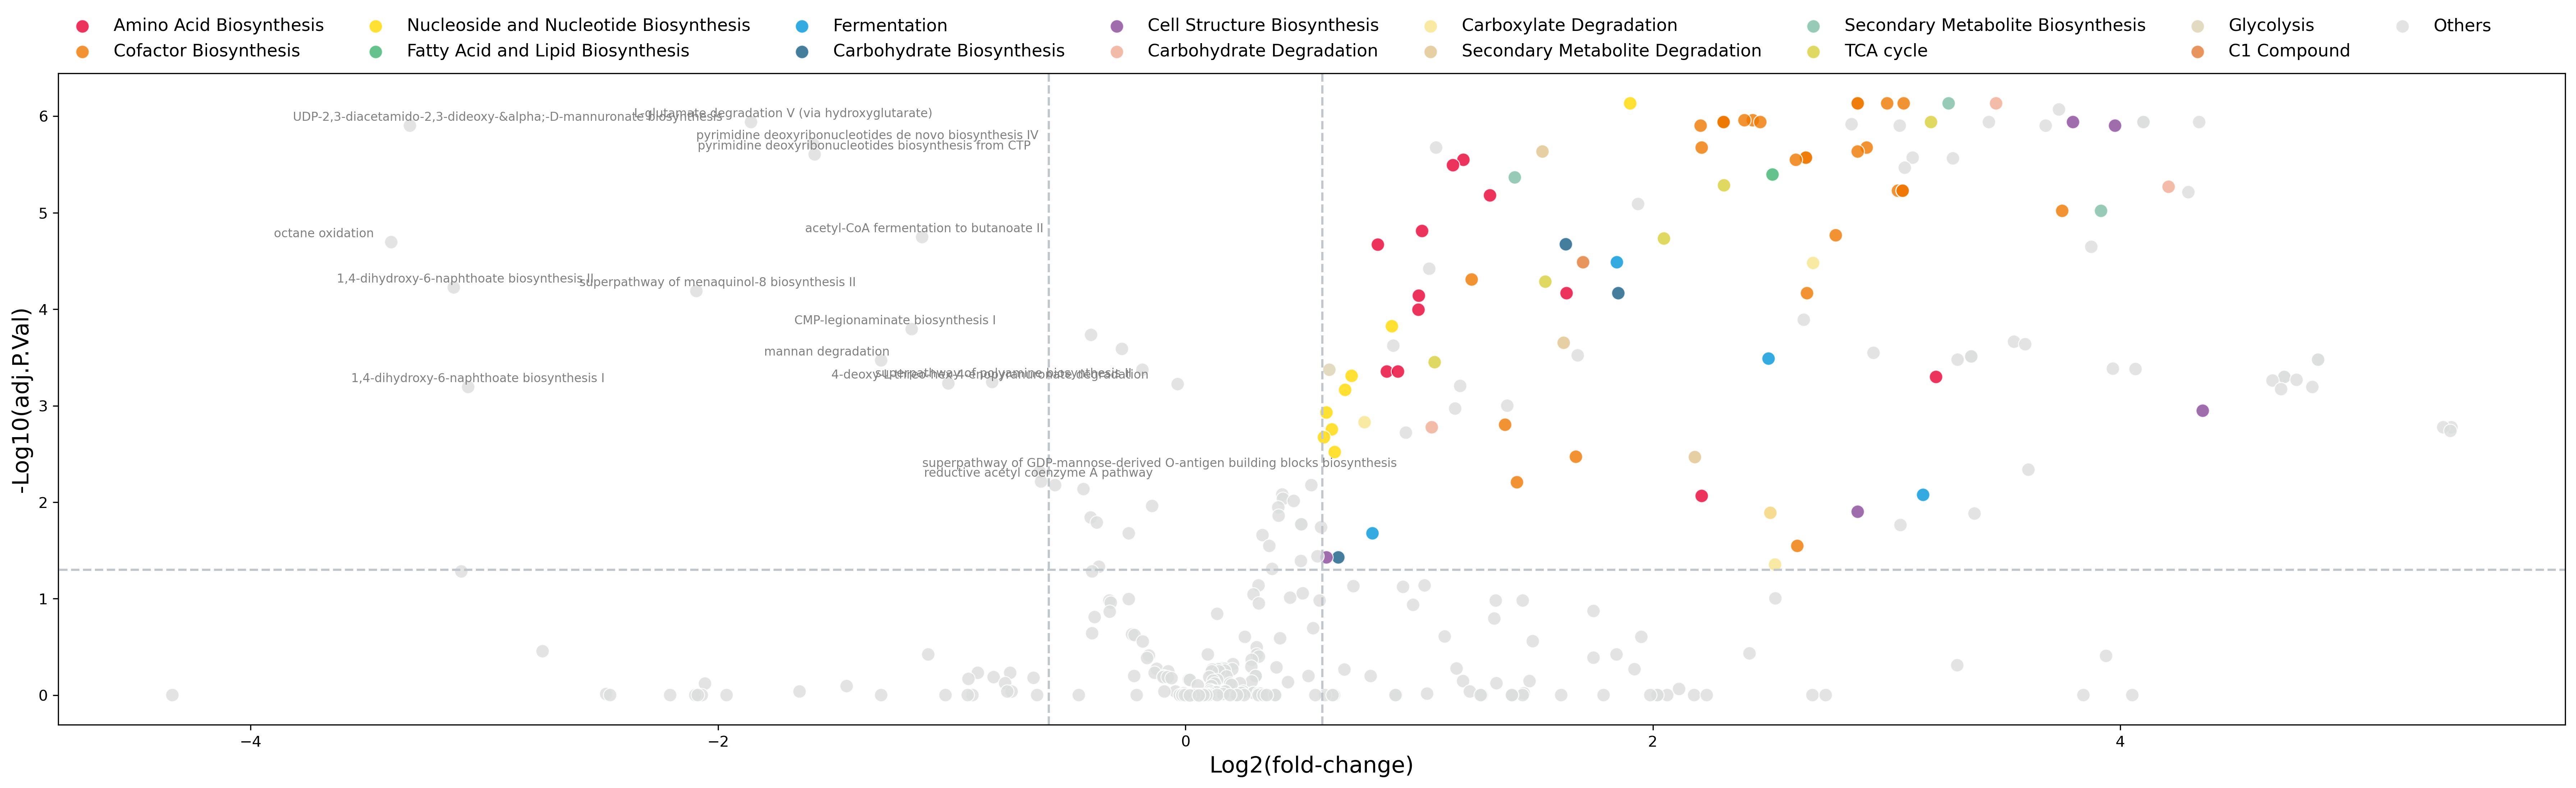

In [128]:
def volcano_plot(statistics, p_col, logfc_col, label_col, color_col, color_legend_col, color_order, p_threshold=0.05, logfc_threshold=0.58, alpha=0.8):
    fig = plt.figure(figsize=(30, 8), dpi=300)
    statistics['-log('+p_col+')'] = -np.log10(statistics[p_col])
    for c in color_order:
        temp = statistics.loc[statistics[color_legend_col]==c, :]
        if temp.shape[0]!=0:
            _ = sns.scatterplot(data=temp, x=logfc_col, y='-log('+p_col+')', color=temp[color_col][0], s=80, label=c, alpha=alpha)
    
    temp = statistics.loc[(statistics[p_col]<=p_threshold)&(statistics[logfc_col]<=-logfc_threshold), :]
    for i in temp.index:
        _ = plt.annotate(temp.loc[i, label_col], temp.loc[i, [logfc_col, '-log('+p_col+')']].values+(-0.5, 0.05), fontsize=8, color='gray')
    
    _ = plt.axvline(x=-logfc_threshold, ymin=0, ymax=7, ls='--', color='#c0c6c9')
    _ = plt.axvline(x=logfc_threshold, ymin=0, ymax=7, ls='--', color='#c0c6c9')
    _ = plt.axhline(y=-np.log10(p_threshold), xmin=-6.5, xmax=6.5, ls='--', color='#c0c6c9')
    _ = plt.xlabel('Log2(fold-change)', fontsize=15)
    _ = plt.ylabel('-Log10('+p_col+')', fontsize=15)
    _ = plt.legend()
    #_ = plt.show()
    return fig


fig = volcano_plot(stats_res, p_col='adj.P.Val', logfc_col='logFC', label_col='Name', color_col='Color', 
                   color_legend_col='Colors_legend', color_order=color_order, p_threshold=0.05, 
                   logfc_threshold=np.log2(1.5), alpha=0.8)
_ = plt.legend(loc=(0.00, 1.01), frameon=False, ncol=8, fontsize=11.5)
fig.savefig('../Results_0609/4.1. pathway差异_MothervsChild.pdf', dpi=300)

In [129]:
stats_res.to_csv('../Results_0609/4.1. pathway差异_MothervsChild.tsv', sep='\t')